     State     Sex GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0  Alabama  Female     Very good                 4.0               0.0   
1  Alabama    Male     Very good                 0.0               0.0   
2  Alabama    Male     Very good                 0.0               0.0   
3  Alabama  Female          Fair                 5.0               0.0   
4  Alabama  Female          Good                 3.0              15.0   

                                     LastCheckupTime PhysicalActivities  \
0  Within past year (anytime less than 12 months ...                Yes   
1  Within past year (anytime less than 12 months ...                Yes   
2  Within past year (anytime less than 12 months ...                 No   
3  Within past year (anytime less than 12 months ...                Yes   
4  Within past year (anytime less than 12 months ...                Yes   

   SleepHours            RemovedTeeth HadHeartAttack  ... HeightInMeters  \
0         9.0            Non

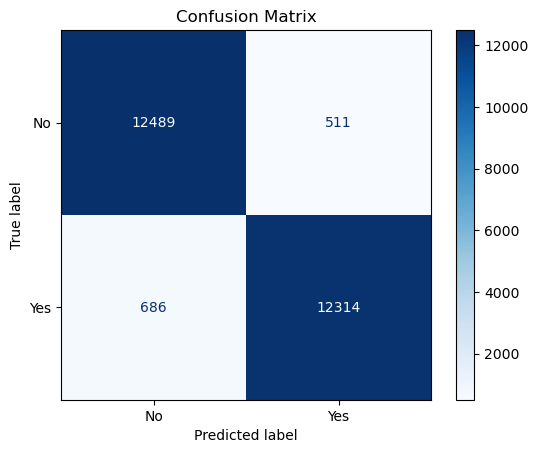


📊 Classification Report:
               precision    recall  f1-score   support

          No       0.95      0.96      0.95     13000
         Yes       0.96      0.95      0.95     13000

    accuracy                           0.95     26000
   macro avg       0.95      0.95      0.95     26000
weighted avg       0.95      0.95      0.95     26000



In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
warnings.filterwarnings("ignore")

data = pd.read_csv("heart_2022_no_nans.csv")
print(data.head())

data.drop("State", axis=1, inplace=True)

chronic_cols = [
    'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 
    'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 
    'HadArthritis', 'HadDiabetes'
]
data['ChronicConditionCount'] = data[chronic_cols].apply(
    lambda row: sum(x == 'Yes' for x in row), axis=1
)

sample_size = 13000
yes_sample = data[data["HadHeartAttack"] == "Yes"].sample(n=sample_size, random_state=42)
no_sample = data[data["HadHeartAttack"] == "No"].sample(n=sample_size, random_state=42)
balanced_data = pd.concat([yes_sample, no_sample])
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
print(balanced_data["HadHeartAttack"].value_counts())

data = balanced_data
X = data.drop("HadHeartAttack", axis=1)
y = data["HadHeartAttack"]

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import joblib

label_encoders = {}
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y)

joblib.dump(target_le, "target_encoder.pkl")
joblib.dump(label_encoders, "label_encoders_heart_attack.joblib")
joblib.dump(X.columns.tolist(), "model_features.pkl")

best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=2,
    random_state=42
)
best_rf.fit(X, y_encoded)

joblib.dump(best_rf, "best_heart_model.pkl")

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_pred = best_rf.predict(X)
cm = confusion_matrix(y_encoded, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print("\n📊 Classification Report:\n", classification_report(y_encoded, y_pred, target_names=["No", "Yes"]))
